# 8 variables, 1 million cells overall. 
## 6 genetic backgrounds
## 4 hidden states (necrosis, apoptosis, healthy/mobile, secreting granzymes?) 

## 8 genetic bgs * 4 reps * 200 images * 150 cells = 0.96 million cells

In [1]:
#death is final 
#kos are initial points
#Gene->fluorescent
#Fluorescent tpA-> fluorescent time point b

## Death is a poisson distribution. taken from both genetic background and prior image of the cell state (n-1 images before, m cells) feeds in, fluorescent
Linear sum of cells in different hidden states (4 states? 5? try different ones) contributing to the next round (do the cells remain dead? Should be), later can fit to data, but currently just simulate and do umap.

GBs also contribute the progression. Have example of gene circuit (general DAG) that leads to influencing the change. Have that contribution be a change in the poisson distribution. Also, should have some t steps before hand to contribute (autoregressive)

In [2]:
import pymc3
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [3]:
# mixture_pdf = [gaussian(5,2), gaussian(8,5), gaussian(3, 2)] 
# deterministic_values = a*b + a*beta1 + b*beta

## Read in covariance matrix

In [4]:
cov = pd.read_excel("simulate_covariance.xlsx", header=None)
cov = cov.fillna(0) + cov.fillna(0).transpose()-(cov.fillna(0)*np.identity(8))

### Draw samples, with different cell types, (here 3), each with varying means in their distribution, but same covariance

In [5]:
def construct_multinomial(n_samples,k=3, prior=True, prior_dist=None, multi_dist=None ):
    #n_samples = 10
    if prior:
        if prior_dist is None:
            prior_dist = np.ones([k,])
        prior_probs = np.random.dirichlet(prior_dist, size=n_samples)
        mixture_prob = np.array(list(map(lambda x: np.random.multinomial(1,pvals=x), prior_probs))).sum(axis=0)
    else:
        if multi_dist is None:
            multi_dist = np.ones([k,])/k 
            multi_dist[-1] = 1-multi_dist[:-1].sum() #Force to sum to one
        mixture_prob = np.random.multinomial(n_samples,pvals=multi_dist)
        
    return mixture_prob


## Create three different means, same covariance structure currently
def create_means(cov, k=3, n_dim=8,init_means=None, random_means=True):
    cell_means = []
    if init_means is None:
        init_means = np.diag(cov)
    print("init_means", init_means)
    for i in range(k):
        if random_means:
            dims = len(init_means)
            curr_inds = np.random.choice(n_dim,np.random.choice(n_dim+1),replace=False)
            print('i',i,'inds to change',curr_inds)
            curr_means = init_means.copy()
            curr_means[curr_inds] = curr_means[curr_inds] + i
            cell_means.append(curr_means)
        else:
            cell_means.append(init_means + i)  
    return cell_means


def construct_data(n_samples=100, num_cells=3, n_dim=8, prior=True, prior_dist=[1,0.5,0.75], 
                  cov_per_cell=None):
    cell_dist = construct_multinomial(n_samples,k=num_cells,prior=prior, prior_dist=prior_dist)
    cell_means = create_means(cov, k=3, n_dim=8,init_means=None)    
    print('cell means',cell_means)
    data = np.infty*np.ones([n_samples,n_dim])
    prev = 0
    for ind, val in enumerate(cell_dist):
        print(ind,val)
        curr_inds = range(prev, prev+val)
        print(len(curr_inds))
        prev += val
        data[curr_inds,:] = np.random.multivariate_normal(cell_means[ind], cov=cov, size=val)
    
    return data, cell_dist

In [6]:
print(construct_multinomial(n_samples=100,k=3, prior=False))
print(construct_multinomial(n_samples=100,k=3, prior=False, multi_dist=[0.1,0.4,0.5]))
print(construct_multinomial(n_samples=100,k=3, prior=True, prior_dist=[1,0.5,1]))

[26 40 34]
[ 6 42 52]
[39 23 38]


# Construct Data

In [7]:
data, cell_dist = construct_data(n_samples=100000)
data

init_means [3. 3. 2. 2. 2. 1. 1. 1.]
i 0 inds to change [2 7 6 1]
i 1 inds to change [3 7 0 5 4]
i 2 inds to change [6 3]
cell means [array([3., 3., 2., 2., 2., 1., 1., 1.]), array([4., 3., 2., 3., 3., 2., 1., 2.]), array([3., 3., 2., 4., 2., 1., 3., 1.])]
0 44285
44285
1 22301
22301
2 33414
33414


/home/isshamie/software/anaconda2/envs/umap/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: covariance is not positive-semidefinite.


array([[ 5.28243423,  4.29992683,  3.30197723, ...,  0.83167277,
         1.01624902, -1.10295345],
       [ 6.87453327,  6.60146282,  5.37766254, ...,  0.3015003 ,
        -0.29128789,  3.81297758],
       [ 5.72851496,  5.26481478,  4.17655563, ...,  0.68483517,
         1.25436698,  2.64236029],
       ...,
       [ 4.79257707,  5.95270367,  3.00952589, ...,  2.97843816,
         5.95150662,  2.47486339],
       [ 3.68896041,  3.38011609,  0.10324396, ..., -3.76845783,
         1.90386274,  2.39807343],
       [ 0.24131409,  3.55417558,  0.90397765, ...,  1.30500389,
         6.01510645,  2.64870938]])

In [8]:
data_df = pd.DataFrame(index=range(data.shape[0]),columns=list(range(data.shape[1])) + ["Label"],dtype=float)
prev = 0
data_df.iloc[:,:-1] = data
data_df.iloc[:,:-1] = data_df.iloc[:,:-1].astype(float)
for ind,val in enumerate(cell_dist):
    data_df.loc[prev:prev+val,"Label"] = ind
    prev += val
data_df["Label"] = data_df["Label"].astype(object)
data_df

,0,1,2,3,4,5,6,7,Label
0,5.282434,4.299927,3.301977,2.389842,2.032914,0.831673,1.016249,-1.102953,0
1,6.874533,6.601463,5.377663,2.395993,5.435698,0.301500,-0.291288,3.812978,0
2,5.728515,5.264815,4.176556,1.849902,2.443642,0.684835,1.254367,2.642360,0
3,0.601682,-1.247951,-1.982294,-0.198258,-1.233892,-0.590500,-0.518841,0.328271,0
4,3.825815,4.187047,2.482325,3.281784,1.793402,0.250987,-2.833328,-3.622783,0
...,...,...,...,...,...,...,...,...,...
99995,2.146899,2.919647,0.483151,5.541734,1.143033,0.072217,6.738090,3.246158,2
99996,4.192613,3.377510,2.718923,4.087001,3.332427,-0.021654,2.212459,4.211421,2
99997,4.792577,5.952704,3.009526,3.240814,2.648247,2.978438,5.951507,2.474863,2
99998,3.688960,3.380116,0.103244,4.799815,-1.390984,-3.768458,1.903863,2.398073,2


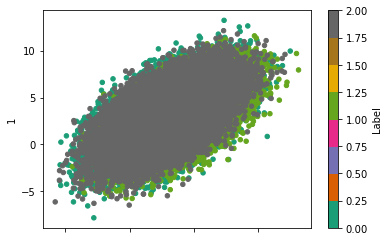

In [9]:
data_df.plot.scatter(0,1,c="Label",cmap='Dark2')

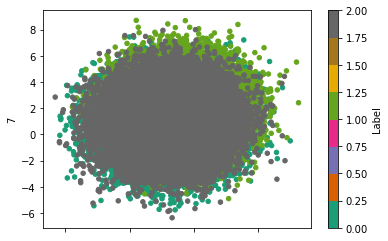

In [10]:
data_df.plot.scatter(0,7,c="Label",cmap='Dark2')

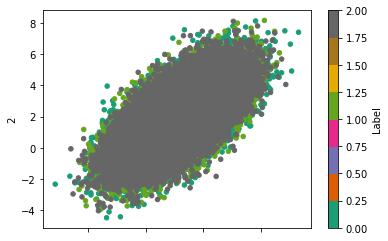

In [11]:
data_df.plot.scatter(1,2,c="Label",cmap='Dark2')

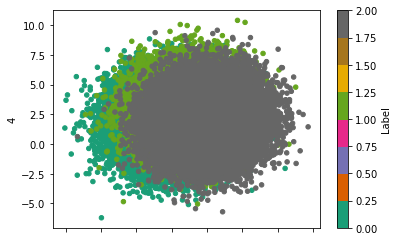

In [12]:
data_df.plot.scatter(3,4,c="Label",cmap='Dark2')

# Run UMAP

In [13]:
t1 = time.time()
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_df.iloc[:,:-1])
embedding.shape
t2 = time.time()
print(f"Time in seconds:{t2-t1}")

/home/isshamie/software/anaconda2/envs/umap/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../home/isshamie/software/anaconda2/envs/umap/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/isshamie/software/anaconda2/envs/umap/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

Time in seconds:138.48619031906128


# Plot UMAP

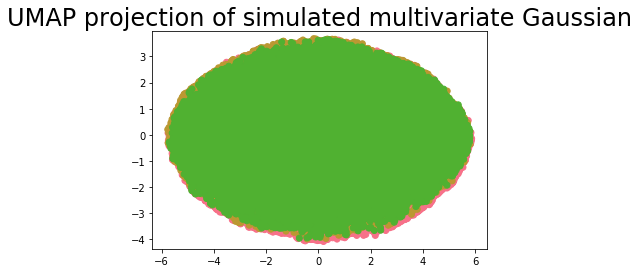

In [22]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette("husl")[int(x)] for x in data_df["Label"].values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of simulated multivariate Gaussian', fontsize=24);


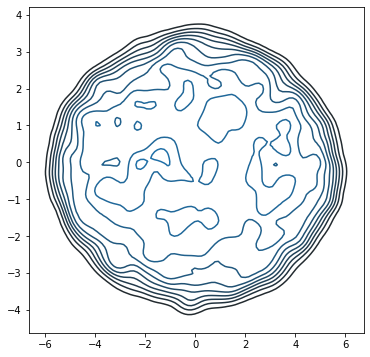

In [24]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(embedding[:, 0], embedding[:, 1], ax=ax)

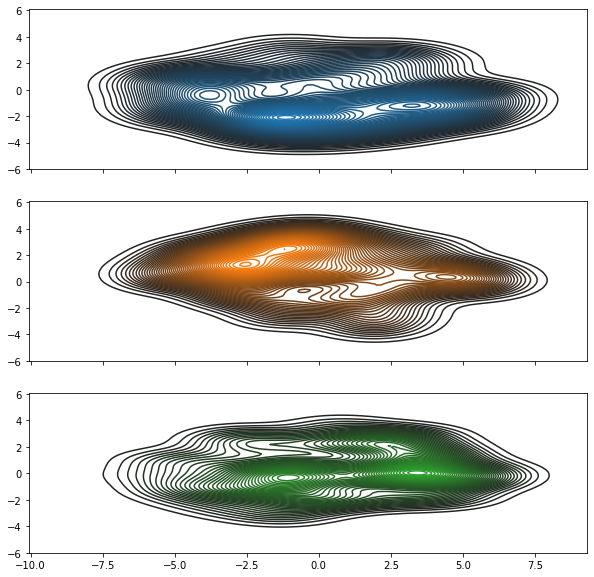

In [53]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(10, 10),sharex=True,sharey=True)
for ind,val in data_df.groupby("Label"):
#     ax[int(ind)].hexbin(embedding[val.index[:100], 0], 
#                 embedding[val.index[:100],1], 
#                 color=sns.color_palette()[int(ind)],gridsize=1000)#,ax=ax[int(ind)])
    
    sns.kdeplot(embedding[val.index[:100], 0], 
                embedding[val.index[:100],1], 
                color=sns.color_palette()[int(ind)],ax=ax[int(ind)], n_levels=60)

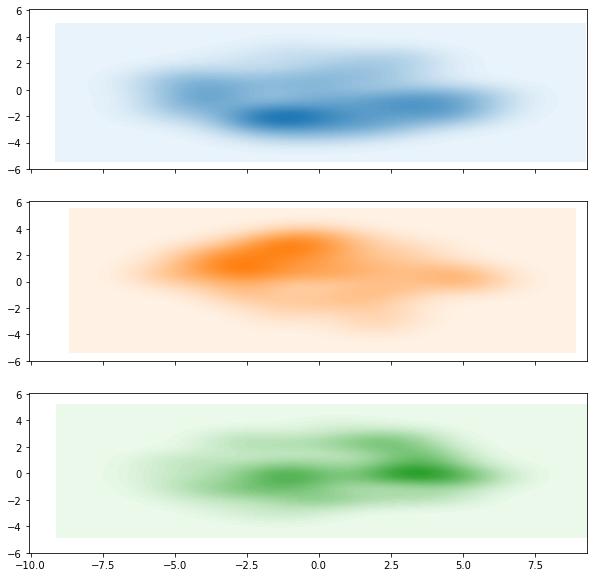

In [58]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(10, 10),sharex=True,sharey=True)
for ind,val in data_df.groupby("Label"):

    sns.kdeplot(embedding[val.index[:100], 0], 
                embedding[val.index[:100],1], 
                color=sns.color_palette()[int(ind)],ax=ax[int(ind)], n_levels=60,shade=True)

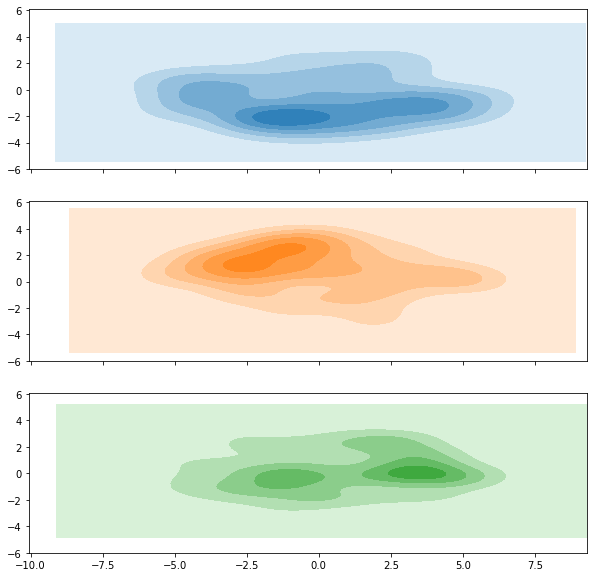

In [59]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(10, 10),sharex=True,sharey=True)
for ind,val in data_df.groupby("Label"):

    sns.kdeplot(embedding[val.index[:100], 0], 
                embedding[val.index[:100],1], 
                color=sns.color_palette()[int(ind)],ax=ax[int(ind)], n_levels=5,shade=True)